In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
dji_mavic_3 = {
    'focal_length': 24,
    'image_width': 1920,
    'image_height': 1080, 
    'sensor_width': 17.75, 
    'sensor_height': 11.83, 
}

def distance_estimation(bbox, altitude=60, cam_angle=20, cam_config=dji_mavic_3): 
    x_min = bbox['x1']
    y_min = bbox['y1']
    x_max = bbox['x2']
    y_max = bbox['y2']

    x_f = (x_min + x_max) / 2
    y_f = y_max
    
    x_c = int(cam_config['image_width'] / 2)
    y_c = int(cam_config['image_height'] / 2)

    f_pixel = (cam_config['focal_length'] / cam_config['sensor_width']) * cam_config['image_width'] # focal length in pixels
    cam_angle = math.radians(cam_angle)
    
    h = altitude / math.cos(cam_angle) 
    theta = math.atan((x_c - x_f) / (y_f - y_c))
    
    if(x_f < x_c and y_f < y_c): # quadrant 2
        theta = theta + 3 * math.pi / 2
    elif(x_f > x_c and y_f < y_c): # quadrant 3
        theta = theta + 3 * math.pi / 2
    elif(x_f > x_c and y_f > y_c): # quadrant 4 
        theta = theta + math.pi / 2
    else: 
        theta = theta + math.pi / 2
    
    delta = math.atan((math.sqrt((x_f - x_c)**2 + (y_f - y_c)**2)) / f_pixel)
    alpha = math.atan(cam_angle)
    r_prime = h * math.tan(delta) / (1 + alpha * math.cos(theta) * math.tan(delta))
    z_prime = alpha * math.sin(theta) * r_prime
    
    distance = math.sqrt(r_prime**2 + (h - z_prime)**2)
    
    return distance, theta

In [3]:
all_data = []
# Calculate distance for all angles and object locations 
for alpha in range(0, 90, 10): 
    for x in range(10, 1940, 12): 
        for y in range(10, 1080, 12): 
            x1 = x - 10
            y1 = y - 10
            x2 = x
            y2 = y 

            bbox = {
                'x1': x1, 
                'y1': y1, 
                'x2': x2, 
                'y2': y2
            }
            
            distance = distance_estimation(bbox=bbox, cam_angle=alpha)
            entry = [x1, y1, x2, y2, alpha, distance[0], distance[1]]
            all_data.append(entry)

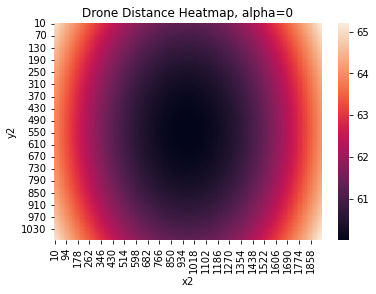

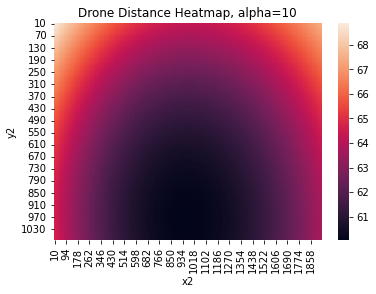

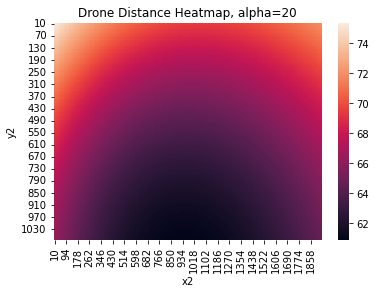

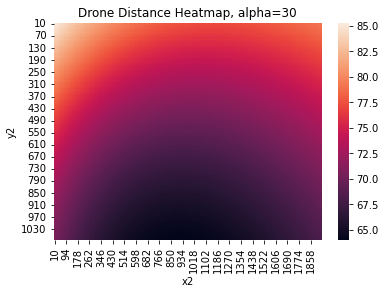

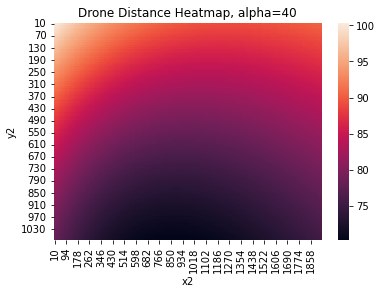

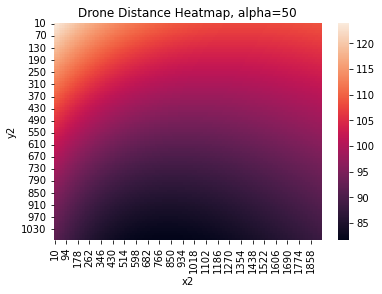

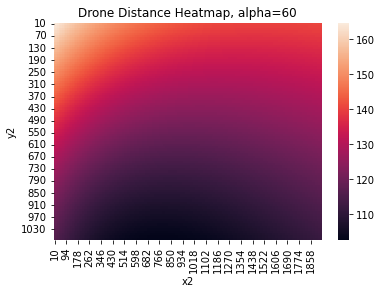

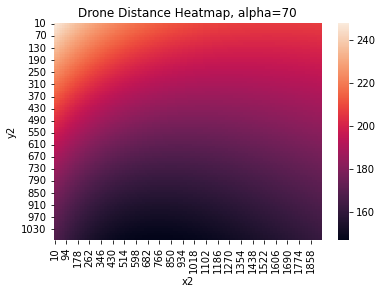

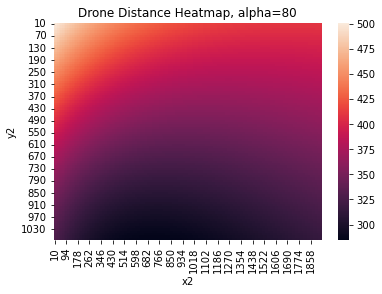

In [4]:
df = pd.DataFrame(all_data, columns=['x1', 'y1', 'x2', 'y2', 'alpha', 'distance', 'theta'])

for alpha in range(0, 90, 10): 
    filter_df = df[df['alpha'] == alpha]
    filter_df = filter_df.pivot('y2', 'x2', 'distance')
    ax = sns.heatmap(filter_df)
    plt.title('Drone Distance Heatmap, alpha={}'.format(alpha))
    plt.show()

# df = df.pivot('y2', 'x2', 'distance')

# alph = 0
# for data in all_data: 
#     df = pd.DataFrame(data, columns=['x1', 'y1', 'x2', 'y2', 'distance', 'theta'])
#     df = df.pivot('y2', 'x2', 'distance')
#     ax = sns.heatmap(df)
#     plt.title('Drone Distance Heatmap, alpha={}'.format(alph))
#     plt.show()
#     alph += 10

In [5]:
x_c = dji_mavic_3['image_width'] / 2
y_c = dji_mavic_3['image_height'] / 2

x_f = 0
y_f = dji_mavic_3['image_height']

theta = math.atan((x_c - x_f) / (y_f - y_c))

print(math.degrees(theta))

60.64224645720873


In [6]:
df

x1    y1    x2    y2  alpha    distance     theta
0          0     0    10    10      0   65.093910  3.648247
1          0    12    10    22      0   65.042290  3.638589
2          0    24    10    34      0   64.991812  3.628829
3          0    36    10    46      0   64.942480  3.618967
4          0    48    10    58      0   64.894295  3.609003
...      ...   ...   ...   ...    ...         ...       ...
130405  1920  1020  1930  1030     80  318.112829  0.469846
130406  1920  1032  1930  1042     80  317.238639  0.479682
130407  1920  1044  1930  1054     80  316.370408  0.489419
130408  1920  1056  1930  1066     80  315.508187  0.499056
130409  1920  1068  1930  1078     80  314.652024  0.508593

[130410 rows x 7 columns]